In [1]:
import scanpy as sc
import numpy as np
import pandas as pd
import anndata as ad
import matplotlib.pyplot as plt
import seaborn as sns

from matplotlib.patches import Patch

import os
import sys
sys.path.insert(0, "/scratch_isilon/groups/singlecell/data/STEREOSEQ_RAW/Stereoseq_analysis/scripts/segmentation_based")

from custom_functions import spatialDensityFeaturePlot, spatialFeaturePlot, spatialClonePlot

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
# Integrate host and microbiome 
#def integrate_microbiome(h_path, m_path):
    #hdata = sc.read_h5ad(h_path)
    #genus_data = sc.read_h5ad(m_path)

    # Convert to DataFrame 
    #df_taxon = pd.DataFrame(
        #genus_data.X.toarray() if hasattr(genus_data.X, "toarray") else genus_data.X,
        #index=genus_data.obs_names,
        #columns=genus_data.var_names)

    # Reindex and fill wit zeros
    #df_taxon = df_taxon.reindex(hdata.obs_names, fill_value=0)

    # Save in .obsm and .uns
    #hdata.obsm["microbiome_genus"] = df_taxon
    #hdata.uns["microbiome_genus_var_names"] = genus_data.var_names.tolist()

    # Binary column for presence of microbiome
    #hdata.obs["has_microbiome_genus"] = hdata.obs_names.isin(genus_data.obs_names)

    #return hdata

In [4]:
# Integrate objects of all chips
#h_B04101E5 = integrate_microbiome("final_B04101E5_host.h5ad", "/home/groups/singlecell/cfernandez/genus_B04101E5_75binS.h5ad")
#h_B04101E3 = integrate_microbiome("final_B04101E3_host.h5ad", "/home/groups/singlecell/cfernandez/genus_B04101E3_75binS.h5ad")
#h_A04100E4 = integrate_microbiome("final_A04100E4_host.h5ad", "/home/groups/singlecell/cfernandez/genus_A04100E4_75binS.h5ad")
#h_upper_left_D03453G3 = integrate_microbiome("final_upper_left_D03453G3_host.h5ad", "/home/groups/singlecell/cfernandez/genus_D03453G3_75binS.h5ad")
#h_upper_right_D03453G3 = integrate_microbiome("final_upper_right_D03453G3_host.h5ad", "/home/groups/singlecell/cfernandez/genus_D03453G3_75binS.h5ad")
#h_bottom_right_D03453G3 = integrate_microbiome("final_bottom_right_D03453G3_host.h5ad", "/home/groups/singlecell/cfernandez/genus_D03453G3_75binS.h5ad")

In [5]:
print(sc.read_h5ad("/home/groups/singlecell/cfernandez/genus_B04101E5_75binS.h5ad").shape)
print(sc.read_h5ad("/home/groups/singlecell/cfernandez/genus_B04101E3_75binS.h5ad").shape)
print(sc.read_h5ad("/home/groups/singlecell/cfernandez/genus_A04100E4_75binS.h5ad").shape)
print(sc.read_h5ad("/home/groups/singlecell/cfernandez/genus_D03453G3_75binS.h5ad").shape)

(4457, 495)
(11100, 729)
(5523, 528)
(6152, 502)


### **Load Integrated Objects**

In [6]:
B04101E5 = sc.read_h5ad("integrated_B04101E5.h5ad")
B04101E3 = sc.read_h5ad("integrated_B04101E3.h5ad")
A04100E4 = sc.read_h5ad("integrated_A04100E4.h5ad")
upper_left_D03453G3 = sc.read_h5ad("integrated_upper_left_D03453G3.h5ad")
upper_right_D03453G3 = sc.read_h5ad("integrated_upper_right_D03453G3.h5ad")
bottom_right_D03453G3 = sc.read_h5ad("integrated_bottom_right_D03453G3.h5ad")

In [7]:
B04101E5

AnnData object with n_obs × n_vars = 54901 × 19167
    obs: 'orig.ident', 'x', 'y', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'total_counts_mito', 'log1p_total_counts_mito', 'pct_counts_mito', 'total_counts_ribo', 'log1p_total_counts_ribo', 'pct_counts_ribo', 'underTissue', 'keep', 'n_counts', 'leiden_0.8', 'has_microbiome_genus'
    var: 'mito', 'ribo', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'mean', 'std'
    uns: 'binSize', 'bin_size', 'bin_type', 'dendrogram_leiden_0.8', 'description', 'hvg', 'leiden', 'leiden_0.8_colors', 'log1p', 'microbiome_genus_var_names', 'neighbors', 'orig_var_names', 'pca', 'rank_genes_leiden_0.8', 'resolution', 'sn', 'spatial', 'umap'
    ob

### **Select important genera**

In [8]:
# genera of interest
target_genera = ["g__Streptococcus", "g__Veillonella", "g__Prevotella", "g__Neisseria", "g__Haemophilus",
                 "g__Fusobacterium", "g__Gemella", "g__Porphyromonas", "g__Rothia", "g__Actinomyces",
                 "g__Leptotrichia", "g__Capnocytophaga", "g__Moraxella",
                 "g__Staphylococcus", "g__Pseudomonas", "g__Bacteroides", "g__Megasphaera",
                 "g__Selenomonas", "g__Corynebacterium", "g__Acinetobacter", "g__Escherichia",
                 "g__Lautropia", "g__Malassezia", "g__Bifidobacterium", "g__Lactobacillus", "g__Cutibacterium"]

In [9]:
# Filter for selected genera
def filter_genera(hdata, genera):
    # Obtain microbiome DataFrame 
    df_micro = hdata.obsm["microbiome_genus"]

    # Search columns with genus of interest
    cols_filtered = [col for col in df_micro.columns if col in genera]

    # Filter
    df_filtered = df_micro[cols_filtered].copy()

    # Save in the object
    hdata.obsm["microbiome_genus_filtered"] = df_filtered
    hdata.uns["microbiome_genus_filtered_var_names"] = cols_filtered

    return hdata

In [10]:
for name, obj in {
    "B04101E5": B04101E5,
    "B04101E3": B04101E3,
    "A04100E4": A04100E4,
    "upper_left_D03453G3": upper_left_D03453G3,
    "upper_right_D03453G3": upper_right_D03453G3,
    "bottom_right_D03453G3": bottom_right_D03453G3}.items():
    
    filter_genera(obj, target_genera)
    print(f"{name}: {len(obj.uns['microbiome_genus_filtered_var_names'])} genera")

B04101E5: 26 genera
B04101E3: 26 genera
A04100E4: 26 genera
upper_left_D03453G3: 26 genera
upper_right_D03453G3: 26 genera
bottom_right_D03453G3: 26 genera


### **Annotations and Clinical data**

In [11]:
# Add annotations by pacient
annotation_maps = {
    "B04101E5": {
        '0': 'Differentiated secretory tumor region',
        '1': 'Low quality',
        '2': 'Neuroendocrine tumor region',
        '3': 'Reactive stroma',
        '4': 'Neuroendocrine tumor region',
        '5': 'Neuroendocrine tumor region',
        '6': 'Reactive stroma'},
    
    "B04101E3": {
        '0': 'Neuroendocrine tumor region',
        '1': 'Low quality',
        '2': 'Reactive stroma',
        '3': 'Reactive stroma',
        '4': 'Normal ciliated respiratory epithelium',
        '5': 'Neuroendocrine tumor region',
        '6': 'Differentiated secretory tumor region'},
    
    "A04100E4": {
        '0': 'Low quality',
        '1': 'Normal ciliated respiratory epithelium',
        '2': 'Differentiated tumor region',
        '3': 'Reactive stroma',
        '4': 'Neuroendocrine tumor region'},
    
    "upper_left_D03453G3": {
        '0': 'Differentiated tumor region',
        '1': 'Differentiated tumor region',
        '2': 'Invasive front'},
    
    "upper_right_D03453G3": {
        '0': 'Reactive stroma',
        '1': 'Differentiated tumor region',
        '2': 'Invasive front',
        '3': 'Differentiated secretory tumor region'},
    
    "bottom_right_D03453G3": {
        '0': 'Reactive stroma',
        '1': 'Neuroendocrine tumor region',
        '2': 'Reactive stroma',
        '3': 'Normal ciliated respiratory epithelium'}}

# Add Clinical status by pacient
clinical_status = {
    "B04101E5": "non-responder",
    "B04101E3": "non-responder",
    "A04100E4": "responder",
    "upper_left_D03453G3": "responder",
    "upper_right_D03453G3": "non-responder",
    "bottom_right_D03453G3": "responder"}

# Assign annotations and status
samples = {
    "B04101E5": B04101E5,
    "B04101E3": B04101E3,
    "A04100E4": A04100E4,
    "upper_left_D03453G3": upper_left_D03453G3,
    "upper_right_D03453G3": upper_right_D03453G3,
    "bottom_right_D03453G3": bottom_right_D03453G3}

for name, adata in samples.items():
    # Detect Leiden resolution
    leiden_key = [col for col in adata.obs.columns if col.startswith("leiden")][0]
    
    # Map annotations
    adata.obs["annotation"] = adata.obs[leiden_key].map(annotation_maps[name])
    
    # Add clinical status
    adata.obs["clinical_status"] = clinical_status[name]

In [12]:
B04101E5

AnnData object with n_obs × n_vars = 54901 × 19167
    obs: 'orig.ident', 'x', 'y', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'total_counts_mito', 'log1p_total_counts_mito', 'pct_counts_mito', 'total_counts_ribo', 'log1p_total_counts_ribo', 'pct_counts_ribo', 'underTissue', 'keep', 'n_counts', 'leiden_0.8', 'has_microbiome_genus', 'annotation', 'clinical_status'
    var: 'mito', 'ribo', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'mean', 'std'
    uns: 'binSize', 'bin_size', 'bin_type', 'dendrogram_leiden_0.8', 'description', 'hvg', 'leiden', 'leiden_0.8_colors', 'log1p', 'microbiome_genus_var_names', 'neighbors', 'orig_var_names', 'pca', 'rank_genes_leiden_0.8', 'resolution

### **Differentially Expressed Microbiome Populations**

In [13]:
def make_pseudobulk_all(samples, target_genera):
    rows = []

    for name, adata in samples.items():
        cs = adata.obs["clinical_status"].iloc[0]  
        micro = adata.obsm["microbiome_genus_filtered"][target_genera].copy()
        ann = adata.obs["annotation"].astype(str)

        # Use all annotations (filter only NaN)
        mask = ann.notna()
        micro = micro.loc[mask]
        ann   = ann.loc[mask]

        if micro.empty:
            continue

        # Pseudobulk = mean per annotation inside the pacient
        pb = micro.groupby(ann).mean()

        # Add metadata
        pb["annotation"] = pb.index
        pb["clinical_status"] = cs
        pb["sample"] = name

        rows.append(pb.reset_index(drop=True))

    if not rows:
        return pd.DataFrame(columns=["annotation","clinical_status","sample"] + target_genera)

    pseudobulk_df = pd.concat(rows, ignore_index=True)

    # Reorder
    return pseudobulk_df[["annotation","clinical_status","sample"] + target_genera]

pseudobulk_df = make_pseudobulk_all(samples, target_genera)
pseudobulk_df.head()

,annotation,clinical_status,sample,g__Streptococcus,g__Veillonella,g__Prevotella,g__Neisseria,g__Haemophilus,g__Fusobacterium,g__Gemella,...,g__Megasphaera,g__Selenomonas,g__Corynebacterium,g__Acinetobacter,g__Escherichia,g__Lautropia,g__Malassezia,g__Bifidobacterium,g__Lactobacillus,g__Cutibacterium
0,Differentiated secretory tumor region,non-responder,B04101E5,0.000308,0.0000,0.000000,0.000062,0.000000,0.000000,0.000000,...,0.000062,0.000062,0.001789,0.002961,0.000123,0.000000,0.028688,0.000185,0.000185,0.005429
1,Low quality,non-responder,B04101E5,0.000154,0.0000,0.000077,0.000077,0.000000,0.000231,0.000154,...,0.000000,0.000000,0.001466,0.003627,0.000077,0.000077,0.026543,0.000386,0.000540,0.005093
2,Neuroendocrine tumor region,non-responder,B04101E5,0.000190,0.0000,0.000127,0.000127,0.000063,0.000000,0.000000,...,0.000000,0.000063,0.001965,0.004311,0.000254,0.000063,0.024849,0.000571,0.000254,0.006403
3,Reactive stroma,non-responder,B04101E5,0.000100,0.0001,0.000100,0.000000,0.000000,0.000000,0.000100,...,0.000000,0.000000,0.002611,0.008537,0.000000,0.000000,0.032841,0.000201,0.000000,0.008235
4,Differentiated secretory tumor region,non-responder,B04101E3,0.003484,0.0000,0.003484,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.001742,0.005226,0.000000,0.000000,0.024390,0.000000,0.000000,0.038328


In [14]:
# Microbiome columns
micro_cols = target_genera

# Add pseudocounts
pseudo_micro = pseudobulk_df[micro_cols] + 1e-6

# CLR: log(x / geometric mean of row)
def clr_transform(X):
    gm = np.exp(np.log(X).mean(axis=1))[:, np.newaxis]
    return np.log(X / gm)

clr_values = clr_transform(pseudo_micro.values)

# Combine with metadata
clr_df = pd.concat([
    pseudobulk_df[["annotation","clinical_status","sample"]].reset_index(drop=True),
    pd.DataFrame(clr_values, columns=micro_cols)], axis=1)

# Combined ID = sample | annotation
clr_df["col_id"] = clr_df["sample"] + " | " + clr_df["annotation"]
clr_df.head()

,annotation,clinical_status,sample,g__Streptococcus,g__Veillonella,g__Prevotella,g__Neisseria,g__Haemophilus,g__Fusobacterium,g__Gemella,...,g__Selenomonas,g__Corynebacterium,g__Acinetobacter,g__Escherichia,g__Lautropia,g__Malassezia,g__Bifidobacterium,g__Lactobacillus,g__Cutibacterium,col_id
0,Differentiated secretory tumor region,non-responder,B04101E5,1.468705,-4.266159,-4.266159,-0.127891,-4.266159,-4.266159,-4.266159,...,-0.127891,3.223885,3.727569,0.557249,-4.266159,5.998102,0.960031,0.960031,4.333551,B04101E5 | Differentiated secretory tumor region
1,Low quality,non-responder,B04101E5,0.341224,-4.704270,-0.345506,-0.345506,-4.704270,0.744541,0.341224,...,-4.704270,2.586739,3.492041,-0.345506,-0.345506,5.482297,1.253644,1.589378,3.831469,B04101E5 | Low quality
2,Neuroendocrine tumor region,non-responder,B04101E5,0.580616,-4.672569,0.177763,0.177763,-0.507589,-4.672569,-4.672569,...,-0.507589,2.911255,3.696499,0.866990,-0.507589,5.448061,1.675735,0.866990,4.092036,B04101E5 | Neuroendocrine tumor region
3,Reactive stroma,non-responder,B04101E5,0.765282,0.765282,0.765282,-3.854105,-3.854105,-3.854105,0.765282,...,-3.854105,4.013854,5.198143,-3.854105,-3.854105,6.545365,1.453488,-3.854105,5.162215,B04101E5 | Reactive stroma
4,Differentiated secretory tumor region,non-responder,B04101E3,4.545033,-3.611283,4.545033,-3.611283,-3.611283,-3.611283,-3.611283,...,-3.611283,3.852172,4.950402,-3.611283,-3.611283,6.490697,-3.611283,-3.611283,6.942667,B04101E3 | Differentiated secretory tumor region


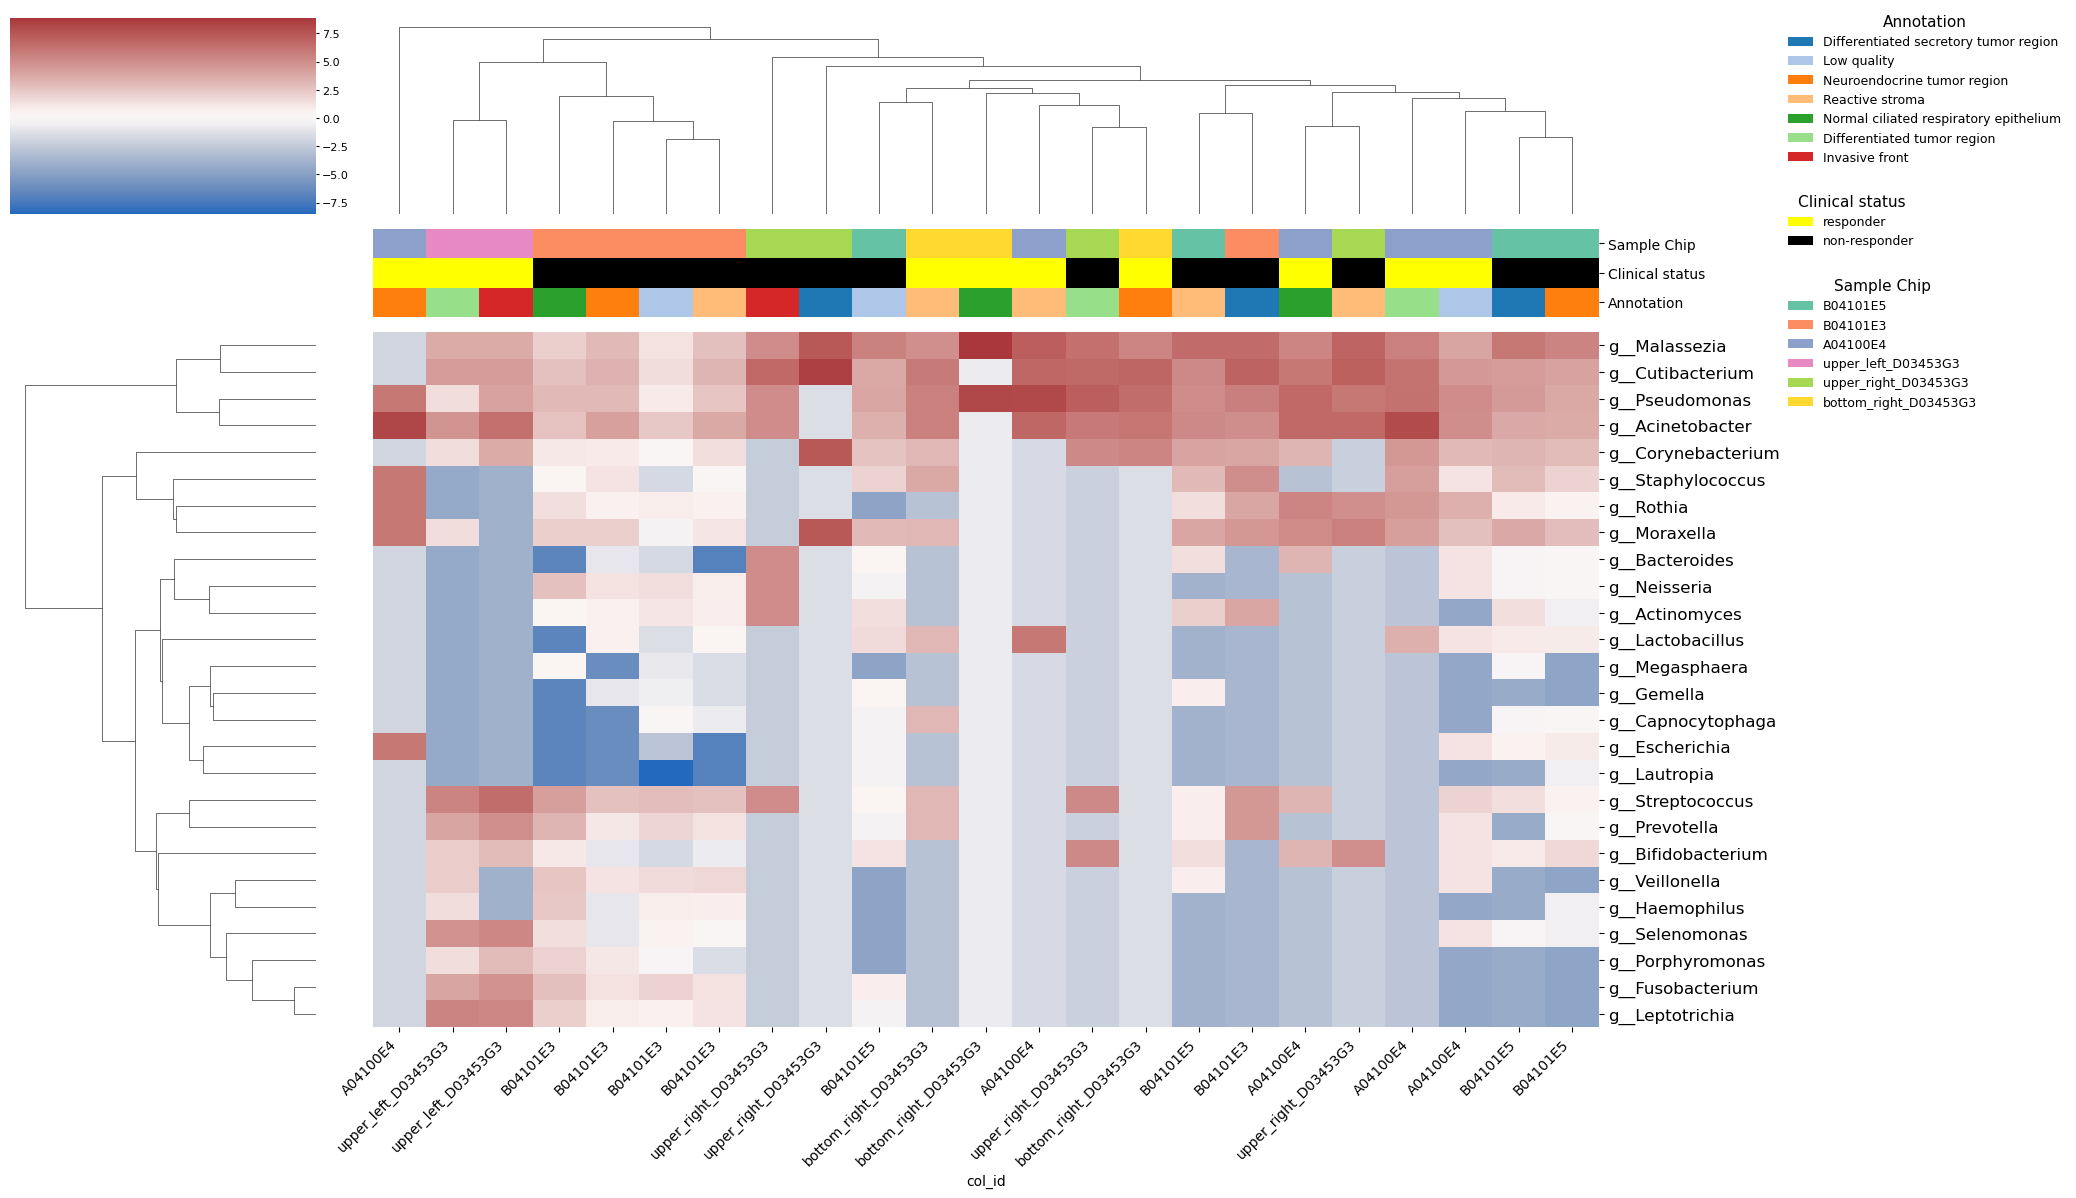

In [17]:
# Dictionary Ids → chips
id_to_chip = {
    "17B0016272": "B04101E3",
    "16B0004595": "B04101E5",
    "18B0000470": "A04100E4",
    "17B0010665 A-1": "upper_left_D03453G3",
    "18B0008518 A-1": "upper_right_D03453G3",
    "18B0001177 A-1": "bottom_right_D03453G3"}

# Create table for clustermap 
clr_df["col_id"] = clr_df["sample"]  # only chip
heatmap_data = clr_df.set_index("col_id")[target_genera].T
col_metadata = clr_df.set_index("col_id")[["annotation", "clinical_status"]]

# Save CHIP name
col_metadata["Sample Chip"] = [id_to_chip.get(sample.split(" | ")[0], sample.split(" | ")[0])
                               for sample in col_metadata.index]

# Palletes 
status_palette = {"responder": "yellow", "non-responder": "black"}

unique_annotations = col_metadata["annotation"].unique()
annotation_palette = dict(zip(
    unique_annotations, sns.color_palette("tab20", len(unique_annotations))))

unique_chips = col_metadata["Sample Chip"].unique()
chip_palette = dict(zip(
    unique_chips, sns.color_palette("Set2", len(unique_chips))))

# Columns colors 
col_colors = pd.DataFrame({
    "Sample Chip": col_metadata["Sample Chip"].map(chip_palette),
    "Clinical status": col_metadata["clinical_status"].map(status_palette),
    "Annotation": col_metadata["annotation"].map(annotation_palette)}, index=col_metadata.index)

# Clustermap
g = sns.clustermap(
    heatmap_data,
    col_colors=col_colors,
    cmap="vlag",
    figsize=(18, 12),
    cbar_pos=(0.90, 0.2, 0.015, 0.6))

plt.setp(g.ax_heatmap.get_xticklabels(), rotation=45, ha="right", fontsize=10)
plt.setp(g.ax_heatmap.get_yticklabels(), fontsize=12)
plt.subplots_adjust(right=0.82)

# Legends 
# Chips
chip_handles = [Patch(facecolor=c, label=lab) for lab, c in chip_palette.items()]
legend_chip = g.fig.legend(
    handles=chip_handles, title="Sample Chip",
    loc="upper left", bbox_to_anchor=(0.99, 0.78),
    frameon=False, title_fontsize=11, fontsize=9)

# Annotations
annotation_handles = [Patch(facecolor=c, label=lab) for lab, c in annotation_palette.items()]
legend_ann = g.fig.legend(
    handles=annotation_handles, title="Annotation",
    loc="upper left", bbox_to_anchor=(0.99, 1),
    frameon=False, title_fontsize=11, fontsize=9)

# Clinical status
status_handles = [Patch(facecolor=c, label=lab) for lab, c in status_palette.items()]
legend_status = g.fig.legend(
    handles=status_handles, title="Clinical status",
    loc="upper left", bbox_to_anchor=(0.99, 0.85),
    frameon=False, title_fontsize=11, fontsize=9)

# Colorbar
g.cax.tick_params(labelsize=8, length=2, pad=2)
plt.tight_layout()
plt.show()
g.savefig("clustermap_.png", dpi=600, bbox_inches='tight')

In [ ]:
# Save clustermap 
#g.savefig("clustermap_.png", dpi=300, bbox_inches='tight')